# Bayesian Changepoint detection

This project is an implementation of Bayesian ChangePoint Detection, from the following paper by Adams and Mackay: https://arxiv.org/abs/0710.3742. This notebook is structed as follows:

- Explanation and maths behind the algorithm
- Toy problem and implementation
- Temperature data
- Bitcoin data
- Coronavirus data - new cases in Great Britain

The objective of the algorithm is to predict the likelihood of changepoint at each datapoint in a timeseries. A changepoint is defined as an underlying change of the factors that control the data. The algorithm is also able to predict the likelihood of run length at each time step, i.e. the number of steps since the last changepoint occured.  

Scroll down if you just wish to see the algorithm ran on real world data and some graphs.  

If there is anything you think I should change, or if you have any ideas for interesting datasets to apply this on, don't hesitate to email me at alex.taylor07@hotmail.co.uk!

## Algorithm intuition and maths 

A timeseries dataset is assumed to comprise of a number of distinct runs, where each run has distinct hyperparameter(s) which control the production of the data in that run. A new run, or changepoint, means there is a change in the hyperparameters. As expected with Bayesian analysis, a prior distribution is added the hyperparameters, and a prior distribution is added to the run lengths.

This algorithm works online, meaning it can analyse each data point as it arrives, as opposed to needing to analyse the data in batches. For each data point, the algorithm calculates the likelihood of each current run length, from 0 (changepoint) up to the position of that datapoint (maximium possible run length).

### Distributions assumed
The length of each run is modelled with a geometric distribution. This distribution models the discrete time until the first failure, or the number of steps until a changepoint. $\gamma$ is the average number of steps until the change. The distribution models the chance of a changepoint occuring at each subsequent datapoint as $1/\gamma$. 

The data is modelled to be from a normal distribution, with a mean value of $\mu$, and standard devition $\sigma_{d}$. A prior is added over $\mu$. This is a normal distribution with mean of 0, and a standard deviation of $\sigma_{mu}$. Here $\sigma_{d}$ and $\sigma_{mu}$ are set as constants.

Therefore we assume a normal distribution creates the data, $D\sim\mathcal{N}(\mu,\sigma_{d}^2)$, and a prior normal distribution which controls the mean $\mu\sim\mathcal{N}(0,\sigma_{\mu}^2)$, and a goemetric distribution which models the number of datapoints until this mean changes.

For each datapoint, we want to calculate the probability of each run length at that point, given the above assumptions. This must be done online, i.e. at any given data point to estimate the probabilities we only use the data up to that point. 

### Algorithm outline

* set run length to 0,

* set likelihood of first run length to 1

* loop through data points/time steps:
 * calculate likelihood equation for r=0
 *   loop through each r value r=1:max r possible
        * check if previous likelihood is below threshold:
            * likelihood = 0
            * continue (skip calculations)     
        * calculate likelihood equation for  at datapoint
 * normalise each r value for this time step
    
### Likelihood updating equation

The likelihood is updated using a message passing system. The joint likelihood of the data and each run length at time t is calculated using the probabilities in the previous step timestep. 

#### No changepoint r > 0

$$r>0, P(r_{t}, x_{1:t}) = P((r-1)_{t-1})*P(r|r-1)*P(x_{t}|x_{t-r:t-1}^{\{r\}}, \sigma_{\mu}, \sigma_{d})$$

#### First term
$P((r-1)_{t-1})$ is the probability of a run length of one less in the previous time step. Due to the online nature of the algorithm this is already calculated.

#### Second term
$P(r|r-1)$ is probability of the run length continuing. This is equal to $1-1/\gamma$ for r>0.

#### Third term when r>0
$P(x_{t}|x_{t-r:t-1}^{\{r\}}, \sigma_{\mu}, \sigma_{d})$ is more complicated. This term is the magic behind the algorithm. This is the probability density of the current data point x_{t} occuring, given the previous x values assumed to belong to this run x_{t-r:t-1}, and the data and hyperparameter standard deviations.

This is known as the posterior predictive distribution:

$$\int_{-\infty}^{\infty} P(x_{t}|\mu, \sigma_{d})*P(\mu|x_{t-r:t-1}^{\{r\}}, \sigma_{\mu}, \sigma_{d}) d\mu$$

i.e. what is the product of the likelihood of $\mu$ given the previous data assumed to belong to this run and the likelihood of the current data point given $\mu$, summed over every possible value of $\mu$,. This is known in the field as marginalising out $\mu$. Given our choice of prior distributions and dependencies, this is available in closed form.

First though we must handle the second term of this:

$$
P(\mu|x_{t-r:t-1}^{\{r\}}, \sigma_{\mu}, \sigma_{d}) \propto P(\mu)*P(x_{t-r:t-1}|\mu, \sigma_{d})
$$

Both the data and hyperparameter following a normal distribution were chosen because a normal is conjugate prior to a normal with unknown mean. A conjugate prior is a prior to a distribution such that the when some data from this distribution is observed, the posterior distribution comes out as the same form as the prior. The parameters of the posterior are updated via simple equations which depend on the data sample and prior parameters. It can be elegantly updated as more data arrives. In my opinion the existance of conjugate priors is one of the most elegant results in statistics. See https://towardsdatascience.com/understanding-conjugate-priors-21b2824cddae for more information on conjugate priors.  

$$
P(\mu|x_{t-r:t-1}^{\{r\}}, \sigma_{\mu}, \sigma_{d}) \sim \mathcal{N}(\mu|\mu'_{0}, \sigma'^{2}_{0})
$$

$$
\mu' = \mu'_{0} + \sum_{t=t-r}^{t-1}{x_{t}}
$$

$$
\sigma'^{2} = (1/\sigma'^{2}_{0}+1/\sigma_{d}^{2})^{-1}
$$

Therefore, for the predictive distribution we have:

$$\int_{-\infty}^{\infty} P(x_{t}|\mu, \sigma_{d})*P(\mu|x_{t-r:t-1}^{\{r\}}, \sigma_{\mu}, \sigma_{d}) d\mu$$

$$\int_{-\infty}^{\infty} \mathcal{N}(x|\mu, \sigma_{d})*\mathcal{N}(\mu|\mu', \sigma'^{2}) d\mu$$

This results in a normal distribution.

$$\int_{-\infty}^{\infty} \mathcal{N}(x|\mu, \sigma_{d})*\mathcal{N}(\mu|\mu', \sigma'^{2}) d\mu = \mathcal{N}(x|\mu', \sigma'^{2}+\sigma_{d}^{2})$$ 

The derivation of this is fairly long. It is done by multipling the two pdfs together, and combining the terms with $\mu$, such that $\mu$ follows a normal distribution pdf. The intergrals are placed around this distribution such that it cancels to 1. The reminder is then the above normal distribution.

#### Changpoint r=0

For a changepoint of zero, the likelihood of the run length stopping on every possible run length of the previous step must be multiplied by the likelihood of the respective runlength from the previous step, and summed.

$$r=0, P(r_{t}, x_{1:t}) = \sum_{r-1} P((r-1)_{t-1})*P(x_{t}|\sigma_{\mu}, \sigma_{d})*P(r|r-1)$$

$$r=0, P(r_{t}, x_{1:t}) = \sum_{r-1} P((r-1)_{t-1})*P(x_{t}|\sigma_{\mu}, \sigma_{d})*(1-1/\gamma)$$

$$
\sum_{r-1} P((r-1)_{t-1}) = 1
$$

The sum of likelihoods in the previous step will have been normalised to equal 1. Therefore it can be cancelled from the equation. 

$$r=0, P(r_{t}, x_{1:t}) = P(x_{t}|\sigma_{\mu}, \sigma_{d})*(1/\gamma)$$

Therefore the likelihood of r=0, is the likelihood of the current x value given the hyperparameter prior distribution, multiplied by the probability that the run length changes at any given step. 

$$P(x_{t}|\sigma_{\mu}, \sigma_{d}) = \int_{-\infty}^{\infty} \mathcal{N}(x|\mu, \sigma_{d})*\mathcal{N}(\mu|0, \sigma_{\mu}^{2}) d\mu 
$$
$$
\sim \mathcal{N}(x_{t}|\mu, \sigma_{\mu}^{2}+\sigma_{d}^2)
$$

A similar process to when r>0 is followed except the conjugate updating is skipped, and the hyperparameter distribution is just used.

#### Intuitition between r>0 and r=0 likelihoods

An intuitive way of looking at this algorithm is looking at the ratio between r=0 and r>0. Due to the normalisation, the ratio between these values is all the matters. r>0 has the term which calculates whether the current x belongs to the set of x's from that run, whereas r=0 just looks at whether x belongs to the general hyperparameter. Therefore if x follows the pattern of previous x's in the run, the likelihood that x belongs to that run will be far higher than x belonging to the general hyperparameter set, whereas if x is an outlier, r>0 will have a far higher likelihood. At each given step, the likelihood of a run ending is $1/\gamma$, therefore the likelihood for a run ending is multipled by that, making it more unlikely. However each run continuing is multiplied by the likelihood of that previous run occuring in the previous step. The data seen in comparison to the previous data allows these factors to be balanced as to whether the run is more likely to continue or end. 

### Normalisation

So far, we have calculated the joint likelihood $P(r_{t}, x_{1:t})$. However, we desire the conditional probability $P(r_{t}|x_{1:t})$. Therefore we need to divide by $P(x_{1:t})$.

$$
P(r_{t}|x_{1:t}) = \frac{P(r_{t}, x_{1:t})}{P(x_{1:t})}
$$

This is done very simply. $P(x_{1:t})$ is the likelyhood of the data up to this point. This is found by summing over every possilble run length.

$$
P(x_{1:t}) = \sum_{r}{P(r_{t}, x_{1:t})}
$$


### Implementation details

Everything is implemented using log probabilities. This helps keep numerical stability, and manipulates information of lower likelihoods more accurately. The one difficulty occurs during the normalisation when the likelihoods needs to be added. This is done by exponating them then adding them, and logging them again. If you know of a better way of dealing with this, please let me know!

I work with precisions instead of standard deviations in the code. This is what I am used to. Using precisions can make some of the maths simpler.

As with each data point, the possible run length increases equally to the length of the data. Therefore as described above the algorithm runs in $\mathcal{O}(N^2)$ time. However, the vast majority of run lengths calculated are extremely unlikely. If the likelyhood of a run length is below a certain threshold, the next run length from it is not calculated, and instead given a likelihood of 0 (log likelihood of negative infinity). This makes the algorithm run in $\mathcal{O}(N)$ (the vast majority of the time), and makes my implementation far far quicker. I find a limit of -10 log likelihood is a good cut off point.  

I store the data in an array of length of the data by a maximum height value specified. This means the vast majority of the array is not fulled. This is fine for the small problems here but a more memory efficient method may need to be used for larger datasets. This felt like the lesser evil in comparison to storing a sequence of varying length arrays in a list. The data all needed to be compiled in one array for plotting regardless. 

Whilst I use the simple unknown mean gaussian likelihood and its conjugate, any likelihood from the exponential family could be used. This is because all exponential likelihoods have a conjugate prior and predictive posterior in closed form. Wikipedia has a table of results for conjuagate pairs and predictive posteriors: https://en.wikipedia.org/wiki/Conjugate_prior.


In [135]:
import numpy as np
import matplotlib.colors as colors
import matplotlib.cbook as cbook
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.preprocessing import StandardScaler
import requests

### Toy dataset

Here a toy dataset is created, this is done by randomly changing the underlying hyperparameter that creates the data. This and the changepoints are plotted to show the type of problem we are dealing with. 

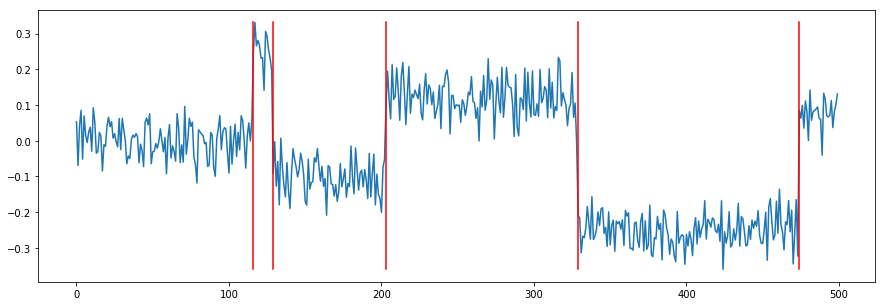

In [10]:
mean = 0.0
std = 0.05
raw_data = []
changed = []
ground_truth = []
time_since_change = 0
for i in range(500):
    if np.random.rand()<0.01:
        time_since_change = 0
        mean = np.random.normal(0, 0.15)
        changed.append(i)
    raw_data.append(np.random.normal(mean, std))
    ground_truth.append(time_since_change)
    time_since_change+=1
plt.figure(figsize=(15, 5))
plt.plot(raw_data)
for i in range(len(changed)):
    plt.plot([changed[i]]*2,[np.min(raw_data),np.max(raw_data)], color='red')

In [23]:
start = time.time()

# this is the length prior
gamma = 1/0.01

# data variance prior
data_variance = 0.05**2
data_prec = 1/data_variance

# hyperparameter mean and variance prior 
hyper_param_mean = 0
hyper_param_var = 0.15**2
hyper_param_prec = 1/hyper_param_var

# we build the dataholder
max_height = np.min([len(raw_data),500])
data_holder = np.zeros((len(raw_data),max_height))

# we set the log probabilities of everything to -np.inf, such that it is handled if the point is not calculated
data_holder[:,:] = -np.inf
# we give the likelihood of a changepoint in the first point a value of 1 (log likelihood of 0)
data_holder[0][0] = 0

limit=-10

for i, current_x in enumerate(raw_data):
    print("\rData point: {}".format(i), end="")
    
    # first point is already given a likelihood of 1
    if i == 0:
        continue
    
    # likelihood of changepoint occuring
    prec = (hyper_param_prec**-1+data_prec**-1)**-1
    change_transition_probability = -0.5*np.log(2*np.pi)+\
                                    0.5*np.log(prec)\
                                    -0.5*(current_x-hyper_param_mean)**2*prec
    data_holder[i][0] = -np.log(gamma)+change_transition_probability
    
    # likelihood or run continuing, from each of the other datapoints
    for j, item in enumerate(data_holder[i-1,:i]):
        
        if j==max_height-1:
            break
            
        # skip the calculates if the previous datapoint has a very low value
        # this saves a lot of time, and stops the O(n2) time 
        if item<limit:
            data_holder[i][j+1]=-np.inf 
            continue
        
        # get the x data, that are assumed to belong to this run
        data_in_run = raw_data[i-j-1:i]
        
        # distribution of the hyperparameter given data and prior - uses normal-normal conjugte pair
        mean = (hyper_param_mean*hyper_param_prec+data_prec*np.sum(data_in_run))/(len(data_in_run)*data_prec+hyper_param_prec)
        prec = (len(data_in_run)*data_prec+hyper_param_prec)
        
        # predictive distribution, used to get the change of current x sharing hyperparameter as the previous x's of this run
        mean = mean
        prec = (prec**-1+data_prec**-1)**-1
        
        # get the probability that the new x belongs to the current run of x's, given the prior information
        transition_probability = -0.5*np.log(2*np.pi)+0.5*np.log(prec)-0.5*(current_x-mean)**2*prec
        
        # add the three log probabilities
        data_holder[i][j+1] = item+np.log(1-gamma**-1)+transition_probability

    # normalise all the probabilities in this run
    data_holder[i,:i+1]-=np.log(np.sum([np.exp(item) for item in data_holder[i,:i+1]]))

print("\nTook {} seconds".format(time.time()-start))

Data point: 499
Took 1.6960227489471436 seconds


### The results are plotted

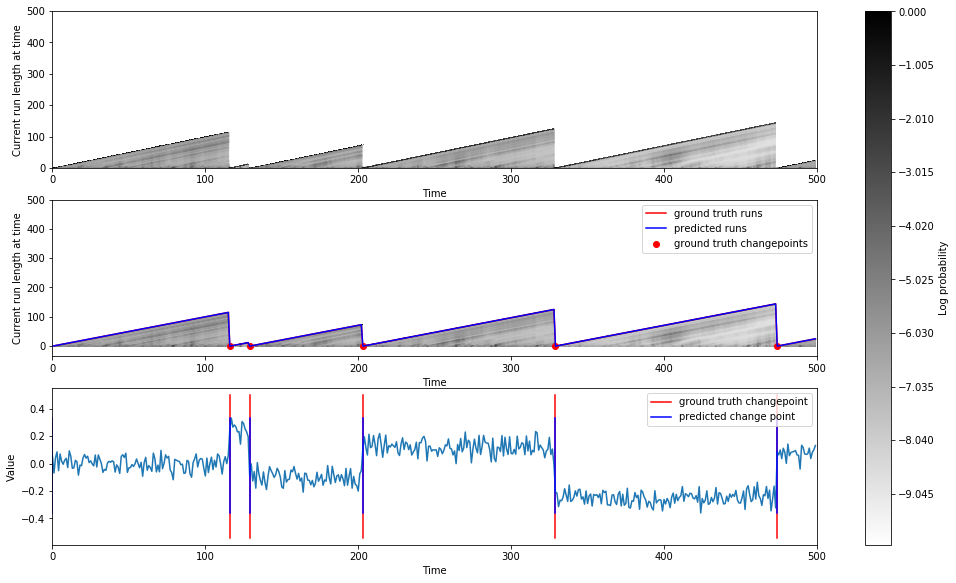

In [24]:
vmin = -10
vmax = 0
levels = np.linspace(vmin, vmax, 200)
fig, axes = plt.subplots(3, 1, figsize=(14, 8))
fig.tight_layout()
for i in range(2):
    a = axes[i].contourf(data_holder.T, levels=levels, cmap='binary')
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Current run length at time")
    m = plt.cm.ScalarMappable(cmap='binary')
    m.set_array(data_holder)
    m.set_clim(-5,6)
    if i==1:
        axes[i].scatter(changed,[0]*len(changed),color='red',  label='ground truth changepoints')
        axes[i].plot(ground_truth, color='red', label='ground truth runs')
        axes[i].plot(np.argmax(data_holder,axis=1), color='blue', label='predicted runs')
        axes[i].legend()
    axes[i].set_xlim([0, len(raw_data)])
fig.colorbar(a, ax=axes.ravel().tolist(), label='Log probability')
for i in range(len(changed)):
    if i==0:
        axes[2].plot([changed[i]]*2,np.array([np.min(raw_data),np.max(raw_data)])*1.5, color='red', label='ground truth changepoint')
    else:
        axes[2].plot([changed[i]]*2,np.array([np.min(raw_data),np.max(raw_data)])*1.5, color='red')
axes[2].plot(raw_data)
axes[2].set_ylabel("Value")
axes[2].set_xlabel("Time")
axes[2].set_xlim([0, len(raw_data)])
axes[2].legend([], loc=1)
predicted_changed = np.where(np.argmax(data_holder,axis=1)==0)[0]
for i in range(len(predicted_changed)):
    if i == 0:
        axes[2].plot([predicted_changed[i]]*2,[np.min(raw_data),np.max(raw_data)], color='blue', label='predicted change point')
    else:
        axes[2].plot([predicted_changed[i]]*2,[np.min(raw_data),np.max(raw_data)], color='blue')
plt.legend(loc=1)    

The top graph shows the trellis like struture of the probability of each run. The dark lines indicate high likelihood. The middle graph shows the predicted runs against the actual runs. The predicted run length is found by taking the most probably run length for each time, i.e. a maximum likelihood approach. The predicted run length and actual run length are very close most of the time. 

However the algorithm misses some changepoints. This can be forgiven when looking at the data and seeing the underlying mean has not changed much. The third graph shows some which changepoints the algorithm predicted, i.e. where a run length of zero was the most likely). It gets a few of these. However we can see that it highlights the occurance of most of the changepoints from the top graph, even if it does not explicitely predict them as the most likely event. This is shown by the dark lines starting at zero.

### The code is written in a class, for easy access for the later problems

In [111]:
class changePointDetector:
    def __init__(self, gamma = 1/0.005, data_variance=0.05**2, prior_mean=0, prior_variance=0.25**2):
        self.gamma = gamma
        self.data_prec = 1/data_variance
        self.hyper_param_mean = prior_mean
        self.hyper_param_prec = 1/prior_variance
        
    
    def __call__(self, data, limit=-50, iterations=False, max_array_height=1000):
        if not iterations:
            iterations=len(data)
        output = []
        self.data = data
        max_height = np.min([len(data), max_array_height])
        self.data_holder = np.zeros((len(data), max_height))
        self.data_holder[:,:] = -np.inf
        self.data_holder[0][0] = 0

        for i, current_x in enumerate(data[:iterations]):
            print("Data point: {} ".format(i),end="\r")
            if i == 0:
                continue

            # calculate the probability of the change point
            prec = (self.hyper_param_prec**-1+self.data_prec**-1)**-1
            change_transition_probability = -0.5*np.log(2*np.pi)\
                                            +0.5*np.log(prec)\
                                            -0.5*(current_x-self.hyper_param_mean)**2*prec
            self.data_holder[i][0] = -np.log(self.gamma)+change_transition_probability
            
            # get probability of it continuing from each possibility
            for j, item in enumerate(self.data_holder[i-1,:i]):
                
                # break if j reaches the max streak size
                if j == max_height - 1:
                    break
                    
                # if probability below a certain limit, don't do calculation, this saves a lot of time
                if limit and item<limit:
                    self.data_holder[i][j+1]=-np.inf 
                    continue
                    
                # get the previous x's, that are assumed to belong to this run
                data_in_run = self.data[i-j-1:i]

                # distribution of the hyperparameter given data and prior - uses normal-normal conjugte pair
                mean = (self.hyper_param_mean*self.hyper_param_prec+
                        self.data_prec*np.sum(data_in_run))/(len(data_in_run)*self.data_prec+self.hyper_param_prec)
                prec = (len(data_in_run)*self.data_prec+self.hyper_param_prec)

                # predictive distribution, used to get the change of current x sharing hyperparameter as the previous x's of this run
                mean = mean
                prec = (prec**-1+self.data_prec**-1)**-1
                transition_probability = -0.5*np.log(2*np.pi)+0.5*np.log(prec)-0.5*(current_x-mean)**2*prec

                # add the three log probabilities
                self.data_holder[i][j+1] = item+np.log(1-self.gamma**-1)+transition_probability
              
            # normalise these probabilities
            self.data_holder[i,:i+1]-=np.log(np.sum([np.exp(item) for item in self.data_holder[i,:i+1]]))

        return self.data_holder
        
    def plot_max(self, vmin=-10):
        fig, axes = plt.subplots(3, 1, figsize=(14, 8))
        fig.tight_layout()
        
        vmin = vmin
        vmax = 0
        levels = np.linspace(vmin, vmax, 100)

        for i in range(2):
            a = axes[i].contourf(self.data_holder.T, levels = levels, cmap='binary')
            axes[i].set_xlabel("Time")
            axes[i].set_ylabel("Current run length at time")
            if i==1:
                axes[i].plot(np.argmax(self.data_holder,axis=1), color='blue', label='predicted runs')
                axes[i].legend()
        fig.colorbar(a, ax=axes.ravel().tolist(), label='Log probability')
        axes[2].plot(self.data)
        axes[2].set_ylabel("Value")
        axes[2].set_xlabel("Time")
        axes[2].set_xlim([0, len(self.data)])
        changed = np.where(np.argmax(self.data_holder,axis=1)==0)[0]
        
        for i in range(len(changed)):
            if i==0:
                axes[2].plot([changed[i]]*2,[np.min(self.data),np.max(self.data)], color='blue', label='predicted changepoints')
            else:
                axes[2].plot([changed[i]]*2,[np.min(self.data),np.max(self.data)], color='blue')
        to_plot = np.argmax(self.data_holder,axis=1)/np.max(np.argmax(self.data_holder,axis=1))*np.max(self.data)/2-\
                  0.75*(np.max(self.data)-np.min(self.data))
        plt.plot(to_plot, color='green',label='predicted run length shape')
        plt.legend(loc=1)    
        
        

### Checking that the class works and gives the same answers as previously

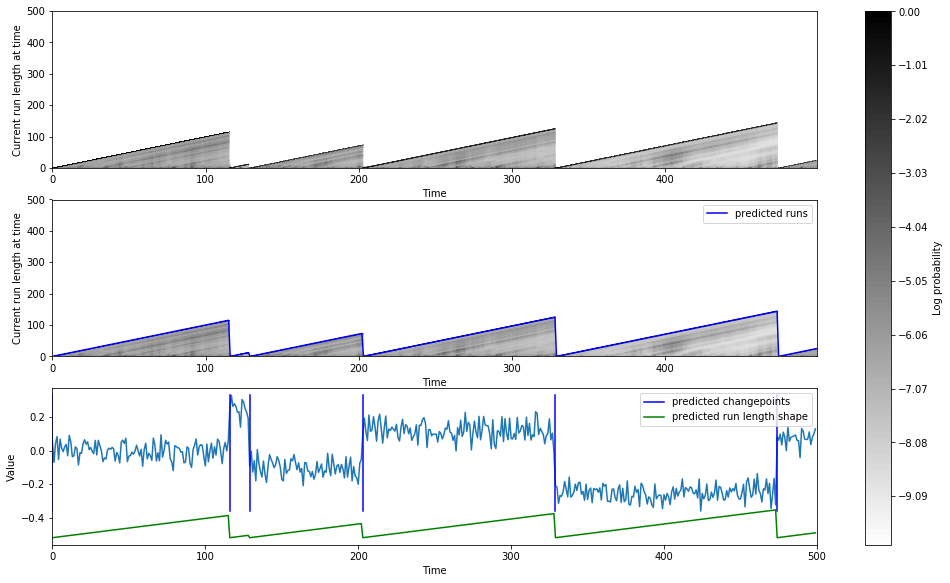

In [34]:
cpd = changePointDetector(gamma = 1/0.01, data_variance=0.05**2, prior_mean=0, prior_variance=0.15**2)
out = cpd(raw_data)
cpd.plot_max()

## Testing on real world data

Here the code has been ran on some real world datasets.

### Climate data

The first is some climate data, obtained from https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip

In [78]:
import tensorflow as tf
import os
import pandas as pd
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df.columns

I am using the temperature data. The resolution of the data is scaled down by a 1000, to make the calculations quicker. This makes each data entry on the x axis one week. We can see each cycle is about 50 weeks, which is about one year.  

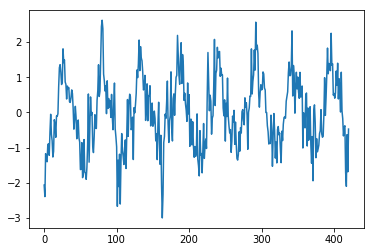

In [462]:
from sklearn.preprocessing import StandardScaler

data = df[df.columns[2]].values[::1000]
standardscaler = StandardScaler()
data_transformed = standardscaler.fit_transform(np.expand_dims(data,1))
plt.plot(data_transformed)

The data is 'standard scaled', meaning it is scaled such is has a mean of 0 and a standard deviation of 1. This massively stabalises the algorithm, helping avoid numerical stability issues. It also means one does not have to worry about ensuring the hyperparameters match the data exactly, and sensible hyperparameters can be reused for different problems. 

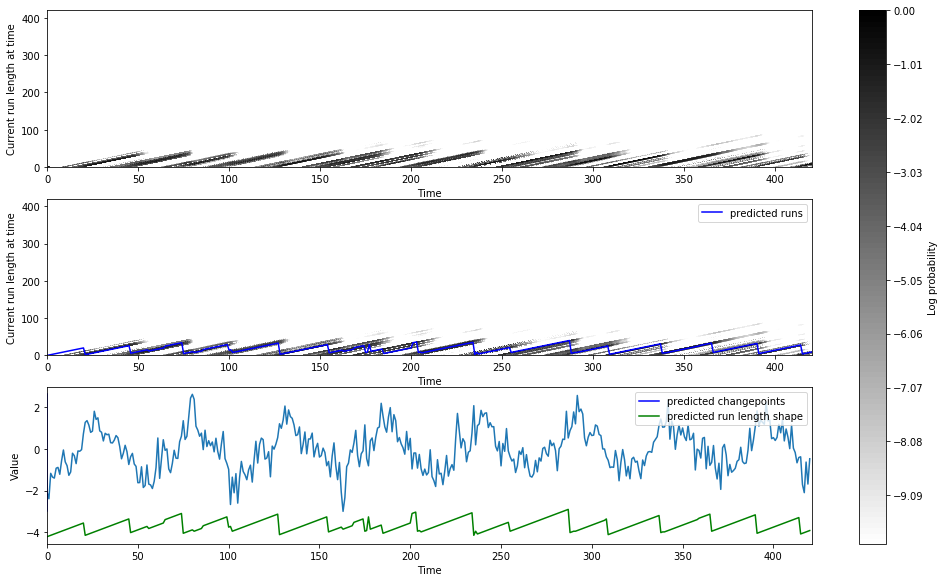

In [463]:
cpd = changePointDetector(gamma = 50, data_variance=1**2, prior_mean=0, prior_variance=10**2)
out = cpd(data_transformed, iterations=500, limit=-50)
cpd.plot_max(-10)

The algorithm clearly highlights the change in temperature pattern every 25 weeks.

## Bitcoin data

The bitcoin data was downloaded from: https://www.kaggle.com/mczielinski/bitcoin-historical-data. It was collected from January 2012 to April 2020. 

In [38]:
csvfile = 'bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv'
bitcoin_data = pd.read_csv(csvfile)

Timestamp
Open
High
Low
Close
Volume_(BTC)
Volume_(Currency)
Weighted_Price


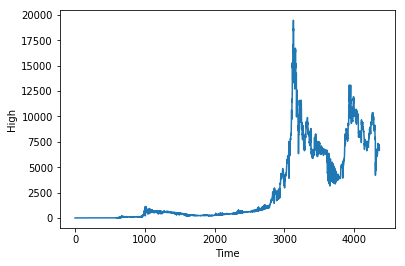

In [130]:
[print(column) for column in bitcoin_data.columns]
#len(bitcoin_data['Volume_(BTC)'])
high = bitcoin_data['High'].values[::1000]
high = pd.Series(high).fillna(pd.Series(high).rolling(200, min_periods=1).mean())
plt.plot(high)
plt.ylabel("High")
plt.xlabel("Time")
standardscaler = StandardScaler()
high_transformed = standardscaler.fit_transform(np.expand_dims(high,1))

The resolution of the data is lowered so it runs a bit quicker and takes less RAM. The data is also standard scaled.

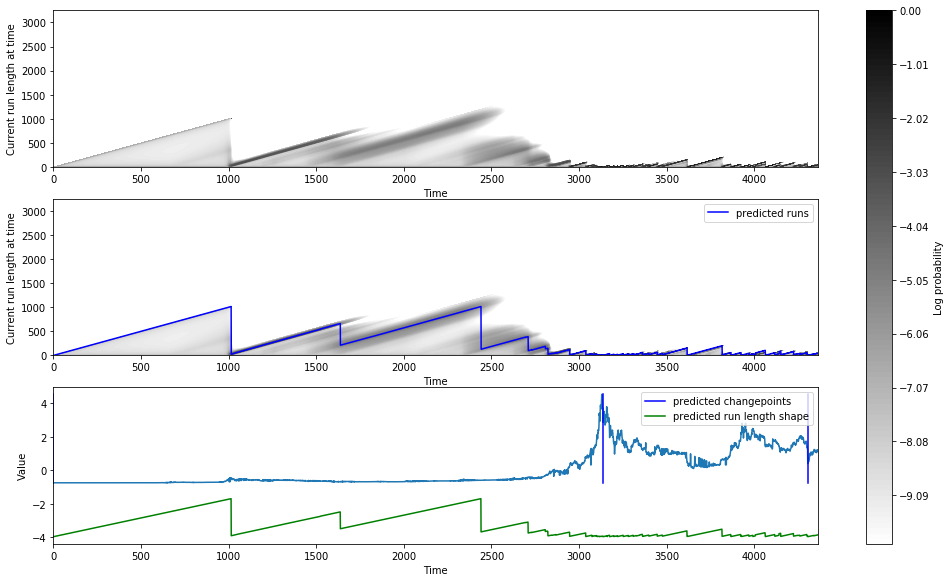

In [118]:
cpd = changePointDetector(gamma = 100, data_variance=0.25**2, prior_mean=0, prior_variance=2**2)
data_out = cpd(high_transformed, limit=-10, max_array_height = 3250)
cpd.plot_max(-10)

We can see it predict a number of changepoints over the years. It captures the major changepoint when Bitcoin hits its December 2017 peak. We see it continue to predict more streaks as the price falls. It then starts to predict another set of runs when the price starts to grow again.

However it would be more impressive if the system was able to predict these peaks from some other information. Below the volume of BTC traded was put into the system. This would perhaps be more useful, as sudden changes in volume may signal that big value changes are approaching.

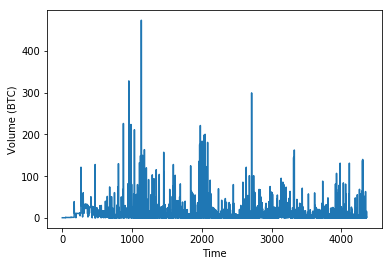

In [131]:
volume = bitcoin_data['Volume_(BTC)'].values[::1000]
volume = pd.Series(volume).fillna(pd.Series(volume).rolling(200, min_periods=1).mean())
plt.plot(volume)
plt.ylabel("Volume (BTC)")
plt.xlabel("Time")
standardscaler = StandardScaler()
volume_transformed = standardscaler.fit_transform(np.expand_dims(volume,1))

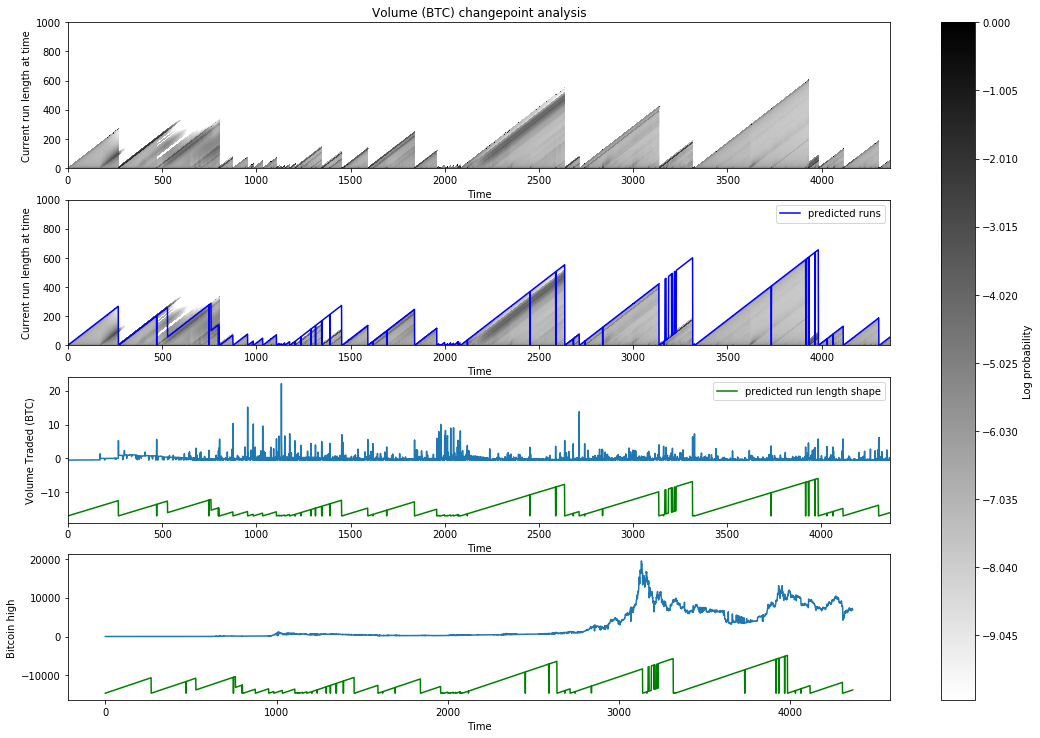

In [133]:
cpd = changePointDetector(gamma = 100, data_variance=1**2, prior_mean=0, prior_variance=2**2)
data_out = cpd(volume_transformed, limit=-10, max_array_height = 1000)
#cpd.plot_max(-10)

raw_data = volume_transformed.copy()
data_holder = data_out.copy()
vmin = -10
vmax = 0
levels = np.linspace(vmin, vmax, 200)
fig, axes = plt.subplots(4, 1, figsize=(15, 10))
fig.tight_layout()
for i in range(2):
    a = axes[i].contourf(data_holder.T, levels=levels, cmap='binary')
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Current run length at time")
    m = plt.cm.ScalarMappable(cmap='binary')
    m.set_array(data_holder)
    m.set_clim(-5,6)
    if i==1:
        axes[i].plot(np.argmax(data_holder,axis=1), color='blue', label='predicted runs')
        axes[i].legend()
    else:
        axes[i].set_title("Volume (BTC) changepoint analysis")

fig.colorbar(a, ax=axes.ravel().tolist(), label='Log probability')
axes[2].plot(raw_data)
axes[2].set_ylabel("Volume Traded (BTC)")
axes[2].set_xlabel("Time")
axes[2].set_xlim([0, len(raw_data)])
axes[2].legend([], loc=1)
to_plot = np.argmax(data_holder,axis=1)/np.max(np.argmax(data_holder,axis=1))*np.max(raw_data)/2-\
                  0.75*(np.max(raw_data)-np.min(raw_data))
axes[2].plot(to_plot, color='green',label='predicted run length shape')
axes[2].legend(loc=1)

axes[3].plot(high)
axes[3].set_ylabel("Bitcoin high")
axes[3].set_xlabel("Time")
to_plot = np.argmax(data_holder,axis=1)/np.max(np.argmax(data_holder,axis=1))*np.max(high)/2-\
                  0.75*(np.max(high)-np.min(high))
axes[3].plot(to_plot, color='green',label='predicted run length shape')

We can see the changepoints calculated from the BTC volume correspond to behaviour in the value. 

## Coronavirus data

Next the system is ran on Coronavirus data case data in Great Britain. The data is extracted using the API from https://thevirustracker.com.

In [136]:
URL = "https://thevirustracker.com/timeline/map-data.json"
covid19data = requests.get(URL).json()

Each case is recorded for each data, including concluded cases. This is so the new cases per day can be calculated by taking the difference in cases each day.

In [138]:
current_cases = []
date_ticks = []
for item in covid19data['data']:
    if item['countrycode'] == 'GB':
        current_cases.append(int(item['cases'])+int(item['deaths'])+int(item['recovered']))
        date_ticks.append(item['date'])

Text(0.5, 1.0, 'Total cases (including concluded) GB')

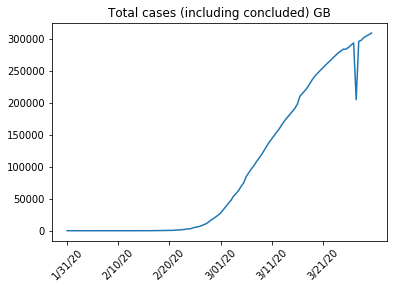

In [139]:
plt.plot(current_cases)
plt.xticks(np.arange(len(current_cases))[::20], date_ticks[::10], rotation=45)
plt.title("Total cases (including concluded) GB")

Due to a wierd spike at the end of the data, the last eight data points are ignored. That spike is likely a measuremeant anomaly, and ruins the calculation of new cases a day. It would need to be smoothed out in a complete system. 

The daily new cases per day from Great Britain are extracted. The tick information is also extracted, and the day the lockdown was imposed is also highlighted. 

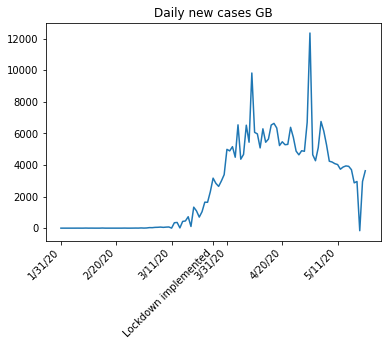

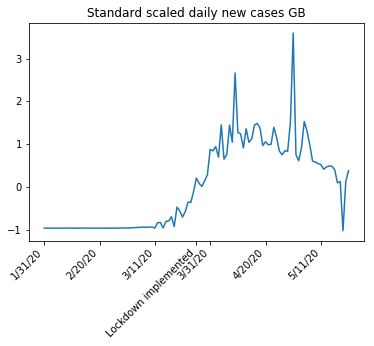

In [144]:
lockdown_tick_position = np.where(np.array(date_ticks)=='3/26/20')[0][0]
new_cases = [float(current_cases[i])-float(current_cases[i-1]) for i in range(1, len(current_cases[:-8]))]
plt.plot(new_cases)
plt.title("Daily new cases GB")
tick_positions = np.arange(len(new_cases))[::20]
ticks = date_ticks[::20]
tick_positions = np.concatenate((tick_positions, [lockdown_tick_position]))
ticks.append('Lockdown implemented')
plt.xticks(tick_positions,ticks, rotation=45, horizontalalignment ='right')

standardscaler = StandardScaler()
new_cases_transformed = standardscaler.fit_transform(np.expand_dims(new_cases,1))
plt.figure()
plt.title("Standard scaled daily new cases GB")
plt.xticks(tick_positions,ticks, rotation=45, horizontalalignment ='right')
plt.plot(new_cases_transformed)


The data is standard scaled aswell, and passed through the changepoint detector. The hyperparameters were sensible values chosen through seeing the scaled data. The graphing was redone, to ensure each axis could be labelled properly.

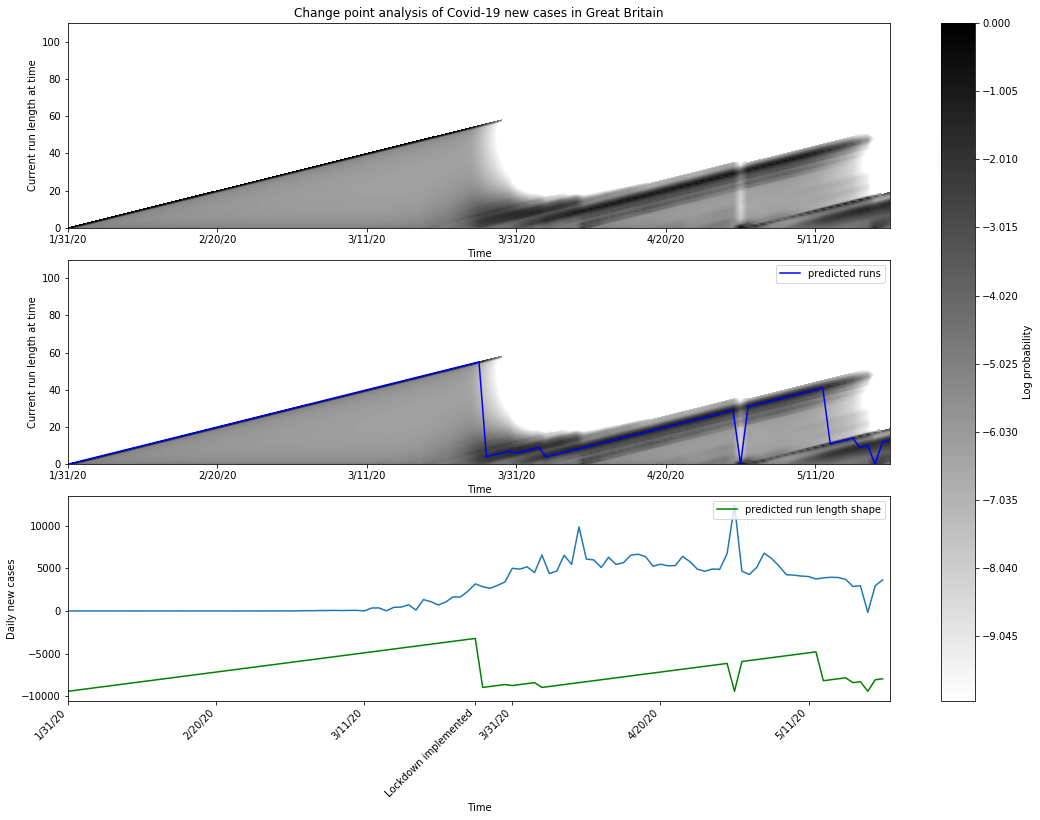

In [148]:
cpd = changePointDetector(gamma = 50, data_variance=0.5**2, prior_mean=0, prior_variance=1**2)
data_out = cpd(new_cases_transformed, limit=-10)
#cpd.plot_max(-10)

raw_data = new_cases.copy()
data_holder = data_out.copy()
vmin = -10
vmax = 0
levels = np.linspace(vmin, vmax, 200)
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
fig.tight_layout()
for i in range(2):
    a = axes[i].contourf(data_holder.T, levels=levels, cmap='binary')
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Current run length at time")
    m = plt.cm.ScalarMappable(cmap='binary')
    m.set_array(data_holder)
    m.set_clim(-5,6)
    if i==1:
        axes[i].plot(np.argmax(data_holder,axis=1), color='blue', label='predicted runs')
        axes[i].legend()
    else:
        axes[i].set_title("Change point analysis of Covid-19 new cases in Great Britain")
    axes[i].set_xticks(tick_positions[:-1])
    axes[i].set_xticklabels(ticks[:-1], rotation=0)


fig.colorbar(a, ax=axes.ravel().tolist(), label='Log probability')
axes[2].plot(raw_data)
axes[2].set_ylabel("Daily new cases")
axes[2].set_xlabel("Time")
axes[2].set_xlim([0, len(raw_data)])
axes[2].legend([], loc=1)
axes[2].set_xticks(tick_positions)
axes[2].set_xticklabels(ticks, rotation=45, horizontalalignment ='right')
to_plot = np.argmax(data_holder,axis=1)/np.max(np.argmax(data_holder,axis=1))*np.max(raw_data)/2-\
                  0.75*(np.max(raw_data)-np.min(raw_data))
axes[2].plot(to_plot, color='green',label='predicted run length shape')
axes[2].legend(loc=1)
pass

The data shows a changpoint when the number of new cases increases rapidly (late March), and shows a changepoint where the new cases start to decrease again (mid May). The Lockdown was implemented late March. This analysis implies it took about a month and a half to create a new changepoint in diagonsed cases. This delay may likely to be due to the delay in symptoms appearing, and the delay in testing people who displayed symptoms. 

Interesting the changepoints predicted are very defined (dark black lines), as opposed to noisy, showing there was a defined major change in pattern late March and mid May. This is not explicitely clear from just looking at the time series data. 

Cleary there are a number of complicated factors affecting this data, such as delay in transmission and the rapid increase in the number of tests, which the model does not account for.  

## Limitations of only modelling the mean

Here the data distribution was assumed to have a set standard deviation, while the mean was given a prior. This means sharp changes in standard deviation cannot be detected. A extension would be to place a prior on the mean and standard deviation. This would mean sudden changes in standard deviation would also register a changepoint, and would negate the need to add a data standard deviation (although a gamma prior for the standard deviation would need to be defined). 

A further extension would be to model a multivariate distribution such that the system could handle two data streams. Changes in either mean or changes in either of variances or covariance would be taken into account when registering a changepoint. 